In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# these two modules are homemade
os.chdir('..')
import gtfs
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

## 1. Load schedule data and stop time estimations
Trip and stop metadata is not required.

In [3]:
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
interpolated = pd.read_csv('dec2015_interpolated.csv')
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['TRIP_ID','STOP_ID'],right_index=True)
del stop_times, tz_sched # to free up memory
interpolated.set_index(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','stop_sequence','STOP_ID'],inplace=True)
print 'Finished loading GTFS data and interpolated stop times and merging.'

Finished loading GTFS data and interpolated stop times and merging.


Convert times to numeric.

In [4]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])
interpolated['arrival_time'] = pd.to_timedelta(interpolated['arrival_time'])

## 2. Create a dataframe containing information about the first and last stop
Because we don't have interpolated data for all stops on each trip, the comparison must be made using travel times only between the first and last stop actually reported.
1. Interpolated arrival time
2. Scheduled arrival time
3. Stop ID

In [5]:
grouped = interpolated.groupby(level=(0,1,2,3))
begins = grouped.min()
ends = grouped.max()
travel_times = begins.join(ends,lsuffix='_begin',rsuffix='_end')
def earliest_stop(g):
    return g.idxmin()[-1][-1]
def latest_stop(g):
    return g.idxmax()[-1][-1]
travel_times['earliest_stop'] = grouped.apply(earliest_stop)
travel_times['latest_stop'] = grouped.apply(latest_stop)

Add calculated columns for travel times (schedule and actual) and also the difference between the two.

In [6]:
travel_times['ttime_schedule'] = (travel_times['arrival_time_end'] - travel_times['arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)
travel_times['ttime_actual'] = (travel_times['interpolated_arrival_time_end'] - travel_times['interpolated_arrival_time_begin'])/ttools.datetime.timedelta(seconds=1)
travel_times['ttime_var'] = travel_times['ttime_actual'] - travel_times['ttime_schedule'] 
# show final dataframe of prepared data
travel_times.head(25)

interpolated_arrival_time_begin  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id                                    
B1       FB_D5-Weekday-SDon-044500_B49_21 2015-12-01 5051                        07:26:18.383065   
                                          2015-12-02 4966                        07:29:27.478322   
                                          2015-12-04 4626                        07:35:24.224470   
                                          2015-12-07 4586                        07:30:07.968671   
         FB_D5-Weekday-SDon-047200_B49_15 2015-12-01 4591                        07:55:39.009698   
                                          2015-12-02 7359                        08:00:01.519994   
                                          2015-12-03 5125                        07:59:41.135254   
                                          2015-12-04 4232                        07:53:19.947106   
                                          2015-12-07 7306                        08:05:53.572070   
         FB_D5-Weekday-SDon-047300_B49_21 2015-12-01 5051                        07:55:20.499186   
                                          2015-12-02 4966                        08:00:05.333194   
                                          2015-12-04 4626                        07:58:39.473770   
                                          2015-12-07 4586                        07:56:47.656308   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-01 4591                        08:33:37.987675   
                                          2015-12-02 7359                        08:36:17.717781   
                                          2015-12-03 5125                        08:38:10.052661   
                                                     7146                        08:34:55.948902   
                                          2015-12-04 4232                        08:39:13.097457   
                                          2015-12-07 7306                        08:39:53.954262   
         FB_D5-Weekday-SDon-051200_B49_21 2015-12-01 5051                        08:34:14.790950   
                                          2015-12-02 4966                        08:36:17.866134   
                                          2015-12-03 7146                        08:52:58.791890   
                                          2015-12-04 4626                        08:39:10.877780   
                                          2015-12-07 4586                        08:34:11.007166   
         UP_D5-Saturday-006000_B1_1       2015-12-05 4867                        01:14:51.611275   

                                                                 arrival_time_begin  \
ROUTE_ID TRIP_ID                          trip_date  vehicle_id                       
B1       FB_D5-Weekday-SDon-044500_B49_21 2015-12-01 5051                  07:26:28   
                                          2015-12-02 4966                  07:26:28   
                                          2015-12-04 4626                  07:28:25   
                                          2015-12-07 4586                  07:28:25   
         FB_D5-Weekday-SDon-047200_B49_15 2015-12-01 4591                  07:53:28   
                                          2015-12-02 7359                  07:57:00   
                                          2015-12-03 5125                  07:55:25   
                                          2015-12-04 4232                  07:53:28   
                                          2015-12-07 7306                  07:55:25   
         FB_D5-Weekday-SDon-047300_B49_21 2015-12-01 5051                  07:54:28   
                                          2015-12-02 4966                  07:58:00   
                                          2015-12-04 4626                  07:56:25   
                                          2015-12-07 4586                  07:56:25   
         FB_D5-Weekday-SDon-051000_B49_15 2015-12-01 4591  

## 3. Show distribution of travel time variance across all trips (or fragments) in data.

In [7]:
def peak_hour(x):
    if x > ttools.datetime.timedelta(hours=6) and x < ttools.datetime.timedelta(hours=9):
        return True
    else:
        if x > ttools.datetime.timedelta(hours=16) and x < ttools.datetime.timedelta(hours=19):
            return True
        else:
            return False
travel_times['P_hour'] = map(lambda x:peak_hour(x),travel_times['arrival_time_begin'])

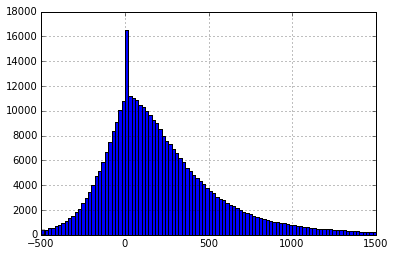

In [9]:
travel_times['ttime_var'].hist(range=(-500,1500),bins=100)

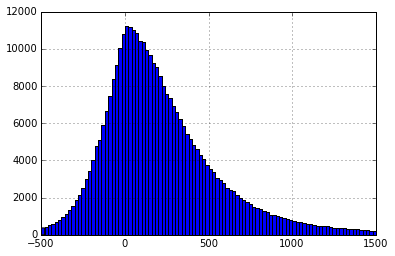

In [10]:
# show without zero-value
travel_times.query('ttime_schedule > 0')['ttime_var'].hist(range=(-500,1500),bins=100)

In [ ]:
ttime_var_pct = travel_times.query('ttime_schedule > 0')['ttime_var']/travel_times.query('ttime_schedule > 0')['ttime_schedule']

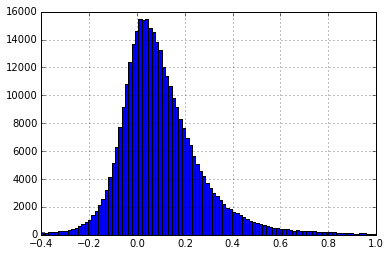

In [11]:
plt.ttime_var_pct.hist(range=(-0.4,1),bins=100)

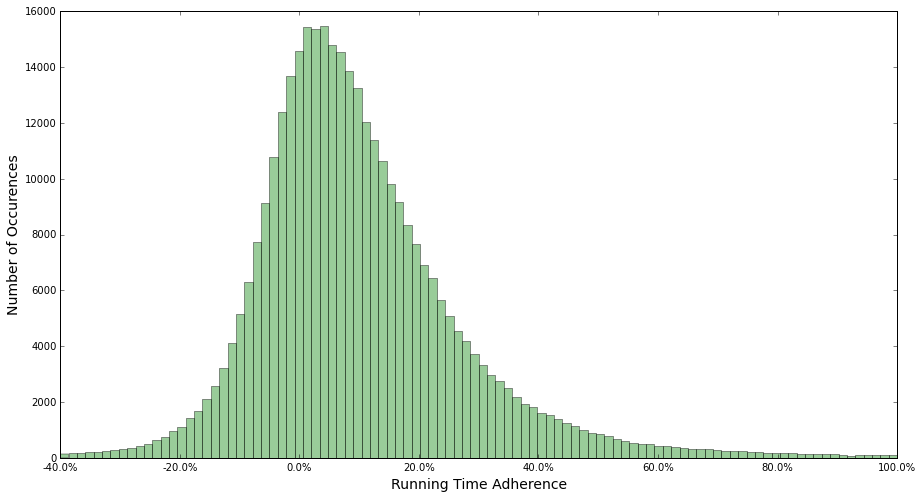

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.hist(ttime_var_pct.values, range=(-0.4,1),bins=100, facecolor='green', alpha=0.4)
plt.ylabel('Number of Occurences', fontsize=14)
plt.xlabel('Running Time Adherence', fontsize=14)
vals = ax.get_xticks()
ax.set_xticklabels(['{:2.1f}%'.format(x*100) for x in vals])
plt.savefig('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/running_time_adherence.png')
plt.show()

## 4. Compare distributions of travel times for the pairing of stops on each route with the most data
First get the pair of stop IDs on each route that have the most number of estimations.

In [12]:
sample_sizes = travel_times.reset_index().groupby(['ROUTE_ID','earliest_stop','latest_stop']).size()
sample_sizes.groupby(level=0).idxmax()

ROUTE_ID
B1        (B1, 300002, 305460)
B100    (B100, 350159, 350184)
B103    (B103, 350208, 304072)
B11      (B11, 307485, 306468)
B12      (B12, 301310, 301343)
B13      (B13, 301880, 801167)
B14      (B14, 301516, 307896)
B15      (B15, 503996, 301092)
B16      (B16, 301603, 307646)
B17      (B17, 307027, 301804)
B2        (B2, 300138, 307636)
B20      (B20, 503454, 307896)
B24      (B24, 302255, 302310)
B25      (B25, 307238, 302440)
B26      (B26, 307699, 801052)
B3        (B3, 300185, 300228)
B31      (B31, 302599, 300182)
B32      (B32, 551925, 306461)
B35      (B35, 302678, 307993)
B36      (B36, 308361, 302868)
B37      (B37, 301722, 901484)
B38      (B38, 307460, 503884)
B39      (B39, 403679, 403679)
B4        (B4, 300285, 307806)
B41      (B41, 307460, 307636)
B42      (B42, 308543, 308106)
B43      (B43, 303710, 308187)
B44      (B44, 308354, 307045)
B44+    (B44+, 307020, 303427)
B45      (B45, 303290, 303198)
                 ...          
X10      (X10, 200316, 403620)

Pick an example, slice the data, and plot the two distributions.

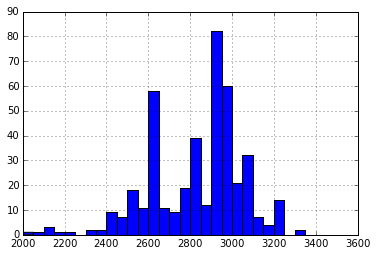

In [22]:
travel_times.loc['B38'].query('earliest_stop == 307460 & latest_stop == 503884')['ttime_schedule'].hist(range=(2000,3500),bins=30)

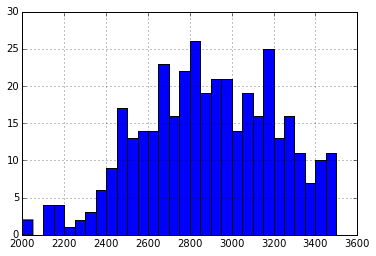

In [23]:
travel_times.loc['B38'].query('earliest_stop == 307460 & latest_stop == 503884')['ttime_actual'].hist(range=(2000,3500),bins=30)

In [26]:
travel_times.loc['B38'].query('earliest_stop == 307460 & latest_stop == 503884')['ttime_schedule'].describe()

count     427.000000
mean     2834.196721
std       224.382823
min      1880.000000
25%      2648.000000
50%      2927.000000
75%      2969.000000
max      3305.000000
Name: ttime_schedule, dtype: float64

In [27]:
travel_times.loc['B38'].query('earliest_stop == 307460 & latest_stop == 503884')['ttime_actual'].describe()

count     427.000000
mean     3018.132919
std       520.092549
min      1929.812898
25%      2694.231736
50%      2937.688106
75%      3218.682982
max      5493.308142
Name: ttime_actual, dtype: float64

In [30]:
travel_times.dtypes

interpolated_arrival_time_begin    timedelta64[ns]
arrival_time_begin                 timedelta64[ns]
interpolated_arrival_time_end      timedelta64[ns]
arrival_time_end                   timedelta64[ns]
earliest_stop                                int64
latest_stop                                  int64
ttime_schedule                             float64
ttime_actual                               float64
ttime_var                                  float64
dtype: object

In [36]:
travel_times.loc['B38'].query('earliest_stop == 307460 & latest_stop == 503884 & P_hour == True')['ttime_actual'].describe()

count     161.000000
mean     3093.651163
std       482.340776
min      2025.998867
25%      2810.714343
50%      3073.956008
75%      3290.911550
max      5242.425850
Name: ttime_actual, dtype: float64

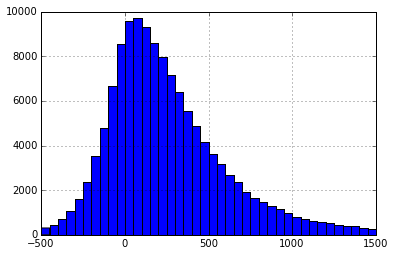

In [37]:
travel_times.query('ttime_schedule > 0 & P_hour == True')['ttime_var'].hist(range=(-500,1500),bins=40)

In [38]:
travel_times.query('ttime_schedule > 0 & P_hour == True')['ttime_var'].describe()

count    133051.000000
mean        306.691456
std         624.634713
min       -3256.385425
25%          12.132715
50%         190.431902
75%         447.618939
max       20211.136295
Name: ttime_var, dtype: float64

In [39]:
travel_times.query('ttime_schedule > 0 & P_hour == False')['ttime_var'].describe()

count    218559.000000
mean        228.195811
std         928.137412
min       -6555.375799
25%         -29.825465
50%         126.933596
75%         351.884667
max      169066.105643
Name: ttime_var, dtype: float64

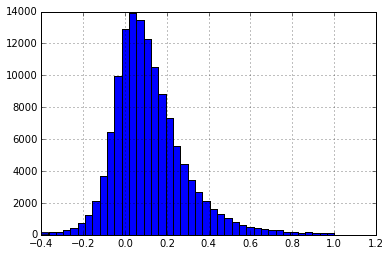

In [40]:
peak_var_pct = travel_times.query('ttime_schedule > 0 & P_hour == True')['ttime_var']/travel_times.query('ttime_schedule > 0 & P_hour == True')['ttime_schedule']
peak_var_pct.hist(range=(-0.4,1),bins=40)

In [41]:
peak_var_pct.describe()

count    133051.000000
mean          0.138769
std           0.320991
min          -0.966475
25%           0.006385
50%           0.091462
75%           0.204776
max          30.262271
dtype: float64

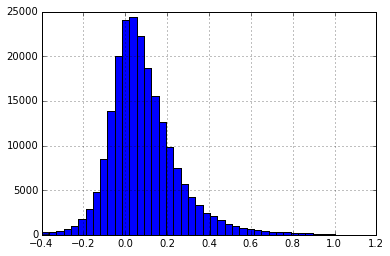

In [42]:
offpeak_var_pct = travel_times.query('ttime_schedule > 0 & P_hour == False')['ttime_var']/travel_times.query('ttime_schedule > 0 & P_hour == False')['ttime_schedule']
offpeak_var_pct.hist(range=(-0.4,1),bins=40)

In [43]:
offpeak_var_pct.describe()

count    218559.000000
mean          0.112539
std           0.782792
min          -0.988446
25%          -0.015799
50%           0.063506
75%           0.169159
max         219.726841
dtype: float64